In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict,cross_val_score
from matplotlib.pyplot import specgram
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes
import xgboost as xgb
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions
from imblearn.over_sampling import RandomOverSampler

/home/kmussar/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
with open('merge_all_redone.pickle', 'rb') as read_file:
    df = pickle.load(read_file)    

# Fix counts of icd9 diagnostics into booleans 

In [4]:
def count2bool(value): 
    if value > 0: 
        return 1

In [5]:
cols2correct = (['No diagnosis','blood',
       'circulatory', 'congenital', 'digestive', 'endocrine',
       'external injury', 'genitourinary', 'infectious',
       'injury and poisoning', 'mental', 'misc', 'muscular', 'neoplasms',
       'nervous', 'perinatal', 'pregnancy', 'respiratory', 'skin',
       'special considerations','CLABSI'])

In [6]:
for col in cols2correct: 
    df[col] = df[col].apply(count2bool)
    df[col] = df[col].fillna(0)

In [7]:
df.infectious.value_counts()

0.0    24665
1.0    13546
Name: infectious, dtype: int64

# Set up Design Matrix

1. Remove columns with id_numbers 
    * icustay_id
    * hadm_id
    * subject_id


2. Remove columns that we would not know at time of admission
    * last_careunit
    * last_wardid
    * outtime
    * los
    * dischtime
    * discharge_location
    * deathtime
    * hospital_expire_flag
    * dod
    * dod_hosp
    * dod_ssn
    * expire_flag


3. Remove unneccesary columns/ colums used for feature engineering
    * starttime
    * endtime
    * dbsource
    * first_wardid
    * intime
    * admittime
    * diagnosis
    * language
    * religion
    * marital_status
    * edregtime
    * edouttime
    * diagnosis
    * has_chartevents_data
    * dob
    * time_before_ICU
    * ER_time
    * age_timedelta
    * religion_bin


4. Remove columns tied too closely to the y
    * duration_hours


In [ ]:
cols2drop = (['icustay_id', 'hadm_id', 'subject_id', 'last_careunit',
              'last_wardid', 'outtime', 'los','dischtime',
              'discharge_location', 'deathtime', 'hospital_expire_flag',
              'dod','dod_hosp', 'dod_ssn', 'expire_flag', 'starttime',
              'endtime', 'dbsource','first_wardid', 'intime', 'admittime',
              'diagnosis', 'language', 'religion','marital_status',
              'edregtime', 'edouttime', 'diagnosis', 'has_chartevents_data',
              'dob', 'time_before_ICU', 'ER_time', 'age_timedelta', 'religion_bin',
              'duration_hours'
             ])

In [ ]:
df_dm = df.drop(columns=cols2drop,axis=1)
df_dm.columns

In [ ]:
len(df_dm.columns)

In [ ]:
df_dm.isna().sum()

In [ ]:
df_dm.drop(columns=['ER_hours'],axis=1,inplace=True)

In [ ]:
df_dm.dropna(axis=0,inplace=True)
df_dm.isna().sum()

In [ ]:
y = df_dm['CLABSI']

In [ ]:
y.value_counts()

In [ ]:
X = df_dm.drop(columns=['CLABSI'],axis=1)

In [73]:
with open('y_correct.pickle','rb') as to_read:
    y = pickle.load(to_read)

In [74]:
with open('X_all_features.pickle','rb') as to_read:
    X = pickle.load(to_read)

In [ ]:
X.info()

## Train/Test Split -- don't cross validate for Feature Selection

In [75]:
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.2,random_state=0)

In [59]:
print("total %: " + str(6427/31754))
print("trainVal %: " + str(5112/25432))
print("train %: " + str(4062/20373))
print("test %: " + str(1315/6322))

total %: 0.20239969767588337
trainVal %: 0.2010066058508965
train %: 0.1993815343837432
test %: 0.2080037962670041


### Let's try dropping columns to see what's most important

**Note: Resampling converts X to numpy.ndarray object -- will test features on not resampled data**

use X and y

In [60]:
# Initalize a base Random Forest 
rf_model = RandomForestClassifier(n_estimators=100,oob_score=True)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_val)
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      5098
         1.0       0.93      0.59      0.72      1011

   micro avg       0.92      0.92      0.92      6109
   macro avg       0.93      0.79      0.84      6109
weighted avg       0.92      0.92      0.92      6109



In [61]:
baseline = rf_model.oob_score_
baseline

0.9259668508287293

In [53]:
lst_cols = list(X_train.columns)
lst_cols

['prior_ICU_hours',
 'age_years',
 'marital_status_bin_MARRIED',
 'marital_status_bin_SINGLE',
 'religion_2_1',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'language_bin_0',
 'admission_type_EMERGENCY',
 'admission_type_URGENT',
 'admission_location_CLINIC REFERRAL/PREMATURE',
 'admission_location_EMERGENCY ROOM ADMIT',
 'admission_location_PHYS REFERRAL/NORMAL DELI',
 'admission_location_TRANSFER FROM HOSP/EXTRAM',
 'first_careunit_CCU',
 'first_careunit_CSRU',
 'first_careunit_MICU',
 'first_careunit_SICU',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Private',
 'insurance_Self Pay',
 'gender_F',
 'No diagnosis',
 'blood',
 'circulatory',
 'congenital',
 'digestive',
 'endocrine',
 'external injury',
 'genitourinary',
 'infectious',
 'injury and poisoning',
 'mental',
 'misc',
 'muscular',
 'neoplasms',
 'nervous',
 'perinatal',
 'pregnancy',
 'respiratory',
 'skin',
 'special considerations']

In [62]:
from sklearn.base import clone

def dropcol_importances(model, X, y):
    model.random_state = 100
    model.fit(X, y)
    baseline = model.oob_score_
    print(baseline)
    imp = []
    for col in lst_cols:
        X2 = X.copy()
        model_ = clone(model)
        model_.random_state = 100
        model_.fit((X2.drop(col, axis=1)), y)
        o = model_.oob_score_
        imp.append(np.absolute(baseline - o))    
    imp = np.array(imp)
    I3 = pd.DataFrame(
            data={'Feature':X.columns,
                  'Absolute Importance':imp})
    #I = I.set_index('Feature')
    I3 = I3.sort_values('Absolute Importance', ascending=True)
    with open ("I3_df.pickle", 'wb') as to_write:
        pickle.dump(I3, to_write)
    
    plt.figure(figsize=(9,3))
    sns.set_context('poster')
    sns.barplot(x='Feature',y='Absolute Importance',data=I3,color='darkblue')
    plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 
    return I3

0.9269081235932065


,Feature,Absolute Importance
3,marital_status_bin_SINGLE,0.000000
2,marital_status_bin_MARRIED,0.000041
10,admission_type_EMERGENCY,0.000082
16,first_careunit_CCU,0.000082
21,insurance_Medicare,0.000164
5,ethnicity_ASIAN,0.000205
7,ethnicity_HISPANIC/LATINO,0.000246
44,special considerations,0.000246
15,admission_location_TRANSFER FROM HOSP/EXTRAM,0.000286
11,admission_type_URGENT,0.000286


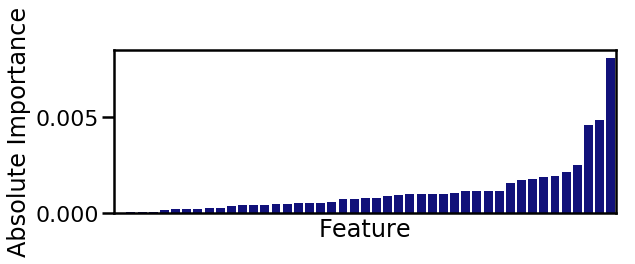

In [63]:
dropcol_importances(rf_model,X_train,y_train)

In [64]:
with open('I3_df.pickle','rb') as to_read:
    I3 = pickle.load(to_read)
I3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 3 to 34
Data columns (total 2 columns):
Feature                45 non-null object
Absolute Importance    45 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [65]:
I3.tail(6)

,Feature,Absolute Importance
38,neoplasms,0.001964
43,skin,0.002169
36,misc,0.002496
31,external injury,0.004584
33,infectious,0.004870
34,injury and poisoning,0.008103


In [42]:
I[I['Absolute Importance'] > 0.003]

,Feature,Absolute Importance
32,genitourinary,0.001637
31,external injury,0.004052
33,infectious,0.006057
34,injury and poisoning,0.009126


In [86]:
clrs = ['darkblue' if x > 0.003 else 'lightgray' for x in I['Absolute Importance']]
clrs

['lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'lightgray',
 'darkblue',
 'darkblue',
 'darkblue']

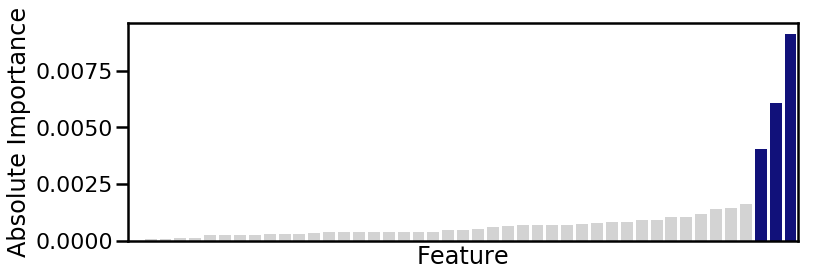

In [90]:
sns.set_context(font_scale=1)

plt.figure(figsize=(12,4))
sns.set_context('poster')
clrs = ['darkblue' if x > .003 else 'lightgray' for x in I['Absolute Importance']]
sns.barplot(x='Feature',y='Absolute Importance',data=I,palette=clrs)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.savefig('Absolute_Importance_grayBlue.jpeg', dpi=300,transparent=True)

In [ ]:
sns.barplot(x='injury and poisoning',y='CLABSI',data=df,color='darkblue')

In [ ]:
sns.barplot(x='gender_F',y='CLABSI',data=df,color='darkblue')

In [ ]:
sns.barplot(x='infectious',y='CLABSI',data=df,color='darkblue')

In [ ]:
sns.barplot(x='external injury',y='CLABSI',data=df,color='darkblue')

In [ ]:
sns.barplot(x='genitourinary',y='CLABSI',data=df,color='darkblue')

In [ ]:
sns.barplot(x='language_bin_0',y='CLABSI',data=df,color='darkblue')

In [ ]:
sns.barplot(x='CLABSI',y='age_years',data=df,color='darkblue')

In [ ]:
sns.barplot(x='ethnicity_BLACK/AFRICAN AMERICAN',y='CLABSI',data=df,color='darkblue')

## Top 7 features (actually 6 since one is "MISC") and Top 4 Features

'injury and poisoning', 'infectious', 'external injury', 'genitourinary', 'language_bin_0', 'age_years'

In [ ]:
X6 = X[['injury and poisoning', 'infectious', 'external injury', 'genitourinary', 'language_bin_0', 'age_years']]

In [ ]:
X4 = X[['injury and poisoning', 'infectious', 'external injury', 'genitourinary']]

### SPLIT

In [ ]:
# Split trainVal set
X6_trainVal, X6_test, y6_trainVal, y6_test = train_test_split(X6, y, test_size=0.2)
X6_train, X6_val, y6_train, y6_val = train_test_split(X6_trainVal, y6_trainVal, test_size=0.2)

In [ ]:
X4_trainVal, X4_test, y4_trainVal, y4_test = train_test_split(X4, y, test_size=0.2)
X4_train, X4_val, y4_train, y4_val = train_test_split(X4_trainVal, y4_trainVal, test_size=0.2)

## Resample

In [76]:
# all features
ros = RandomOverSampler(random_state=0)

print("Train:")
print('Original dataset shape %s' % Counter(y_train))
X_trainRes, y_trainRes = ros.fit_resample(X_train,y_train)
print('Resampled dataset shape %s' % Counter(y_trainRes))

print("Validate:")
print('Original dataset shape %s' % Counter(y_val))
X_valRes, y_valRes = ros.fit_resample(X_val,y_val)
print('Resampled dataset shape %s' % Counter(y_valRes))

Train:
Original dataset shape Counter({0.0: 20321, 1.0: 4114})
Resampled dataset shape Counter({0.0: 20321, 1.0: 20321})
Validate:
Original dataset shape Counter({0.0: 5098, 1.0: 1011})
Resampled dataset shape Counter({0.0: 5098, 1.0: 5098})


In [ ]:
ros6 = RandomOverSampler(random_state=0)

print("Train:")
print('Original dataset shape %s' % Counter(y6_train))
X6_trainRes, y6_trainRes = ros6.fit_resample(X6_train,y6_train)
print('Resampled dataset shape %s' % Counter(y6_trainRes))

print("Validate:")
print('Original dataset shape %s' % Counter(y6_val))
X6_valRes, y6_valRes = ros6.fit_resample(X6_val,y6_val)
print('Resampled dataset shape %s' % Counter(y6_valRes))

In [ ]:
ros4 = RandomOverSampler(random_state=0)

print("Train:")
print('Original dataset shape %s' % Counter(y4_train))
X4_trainRes, y4_trainRes = ros4.fit_resample(X4_train,y4_train)
print('Resampled dataset shape %s' % Counter(y4_trainRes))

print("Validate:")
print('Original dataset shape %s' % Counter(y4_val))
X4_valRes, y4_valRes = ros4.fit_resample(X4_val,y4_val)
print('Resampled dataset shape %s' % Counter(y4_valRes))

In [ ]:
# Just 1 feature

X1 = X[['injury and poisoning']]
# Split trainVal set
X1_trainVal, X1_test, y1_trainVal, y1_test = train_test_split(X1, y, test_size=0.2)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_trainVal, y1_trainVal, test_size=0.2)

In [ ]:
ros1 = RandomOverSampler(random_state=0)

print("Train:")
print('Original dataset shape %s' % Counter(y1_train))
X1_trainRes, y1_trainRes = ros1.fit_resample(X1_train,y1_train)
print('Resampled dataset shape %s' % Counter(y1_trainRes))

print("Validate:")
print('Original dataset shape %s' % Counter(y1_val))
X1_valRes, y1_valRes = ros1.fit_resample(X1_val,y1_val)
print('Resampled dataset shape %s' % Counter(y1_valRes))

In [77]:
pipe_lr_ss = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=42))])

pipe_knn_ss = Pipeline([('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier(n_neighbors=5))])

pipe_rf_ss = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(n_estimators=100))])

pipe_svm_ss = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(kernel="linear"))])

pipe_nb_ss = Pipeline([('scl', StandardScaler()),('clf',naive_bayes.GaussianNB())])

pipelines = [pipe_lr_ss, pipe_knn_ss, pipe_rf_ss, pipe_nb_ss] #, pipe_svm_ss]



In [ ]:
# ALL FEATURES

for p in pipelines:
    p.fit(X_trainRes, y_trainRes)
    prediction_name = (str(p) + "_predictions")
    prediction_name = p.predict(X_valRes)
    print(p)
    print(classification_report(y_valRes,prediction_name))
    print(confusion_matrix(y_valRes,prediction_name))

In [ ]:
# TOP 4 FEATURES

for p in pipelines:
    p.fit(X4_trainRes, y4_trainRes)
    prediction_name = (str(p) + "_predictions" + "4")
    print(prediction_name)
    prediction_name = p.predict(X4_valRes)
    print(classification_report(y4_valRes,prediction_name))
    print(confusion_matrix(y4_valRes,prediction_name))

In [ ]:
# TOP 6 FEATURES

for p in pipelines:
    p.fit(X6_trainRes, y6_trainRes)
    prediction_name = (str(p) + "_predictions" + "6")
    print(prediction_name)
    prediction_name = p.predict(X6_valRes)
    print(classification_report(y6_valRes,prediction_name))
    print(confusion_matrix(y6_valRes,prediction_name))

In [ ]:
# TOP 1 FEATURE

for p in pipelines:
    p.fit(X1_trainRes, y1_trainRes)
    prediction_name = (str(p) + "_predictions" + "1")
    print(prediction_name)
    prediction_name = p.predict(X1_valRes)
    print(classification_report(y1_valRes,prediction_name))
    print(confusion_matrix(y1_valRes,prediction_name))

In [ ]:
# TOP 2

num_features = [2,3]
features = ['injury and poisoning', 'infectious', 'external injury']

X2 = X[['injury and poisoning','infectious']]
# Split trainVal set
X2_trainVal, X2_test, y2_trainVal, y2_test = train_test_split(X2, y, test_size=0.2)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_trainVal, y2_trainVal, test_size=0.2)

ros2 = RandomOverSampler(random_state=0)

print("Train:")
print('Original dataset shape %s' % Counter(y2_train))
X2_trainRes, y2_trainRes = ros2.fit_resample(X2_train,y2_train)
print('Resampled dataset shape %s' % Counter(y2_trainRes))

print("Validate:")
print('Original dataset shape %s' % Counter(y2_val))
X2_valRes, y2_valRes = ros2.fit_resample(X2_val,y2_val)
print('Resampled dataset shape %s' % Counter(y2_valRes))

for p in pipelines:
    p.fit(X2_trainRes, y2_trainRes)
    prediction_name = (str(p) + "_predictions" + "2")
    print(prediction_name)
    prediction_name = p.predict(X2_valRes)
    print(classification_report(y2_valRes,prediction_name))
    print(confusion_matrix(y2_valRes,prediction_name))

In [78]:
# TOP 3

num_features = [2,3]
features = ['injury and poisoning', 'infectious', 'external injury']

X3 = X[['injury and poisoning','infectious','external injury']]
# Split trainVal set
X3_trainVal, X3_test, y3_trainVal, y3_test = train_test_split(X3, y, test_size=0.2)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3_trainVal, y3_trainVal, test_size=0.2)

ros3 = RandomOverSampler(random_state=0)

print("Train:")
print('Original dataset shape %s' % Counter(y3_train))
X3_trainRes, y3_trainRes = ros3.fit_resample(X3_train,y3_train)
print('Resampled dataset shape %s' % Counter(y3_trainRes))

print("Validate:")
print('Original dataset shape %s' % Counter(y3_val))
X3_valRes, y3_valRes = ros3.fit_resample(X3_val,y3_val)
print('Resampled dataset shape %s' % Counter(y3_valRes))

for p in pipelines:
    p.fit(X3_trainRes, y3_trainRes)
    prediction_name = (str(p) + "_predictions" + "3")
    print(prediction_name)
    prediction_name = p.predict(X3_valRes)
    print(classification_report(y3_valRes,prediction_name))
    print(confusion_matrix(y3_valRes,prediction_name))

Train:
Original dataset shape Counter({0.0: 20342, 1.0: 4093})
Resampled dataset shape Counter({0.0: 20342, 1.0: 20342})
Validate:
Original dataset shape Counter({0.0: 5072, 1.0: 1037})
Resampled dataset shape Counter({0.0: 5072, 1.0: 5072})
Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])_predictions3
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      5072
         1.0       0.67      0.67      0.67      5072

   micro avg       0.67      0.67      0.67     10144
   macro avg       0.67      0.67      0.67     10144
weighted avg       0.67      0.67      0.67     10144

[[3430 1642]
 [1690 3382]]


/home/kmussar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])_predictions3
              precision    recall  f1-score   support

         0.0       0.54      0.88      0.67      5072
         1.0       0.67      0.24      0.35      5072

   micro avg       0.56      0.56      0.56     10144
   macro avg       0.60      0.56      0.51     10144
weighted avg       0.60      0.56      0.51     10144

[[4480  592]
 [3869 1203]]
Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
        ...obs=None,
            oo

# ROC Curves

In [79]:
# All features
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=100))])

pipe_lr.fit(X_trainRes, y_trainRes)
predictions = pipe_lr.predict(X_valRes)
print(classification_report(y_valRes,predictions))
print(confusion_matrix(y_valRes,predictions))

/home/kmussar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73      5098
         1.0       0.73      0.75      0.74      5098

   micro avg       0.73      0.73      0.73     10196
   macro avg       0.73      0.73      0.73     10196
weighted avg       0.73      0.73      0.73     10196

[[3661 1437]
 [1271 3827]]


In [ ]:
# Top 4 features

pipe_lr4 = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=100))])

pipe_lr4.fit(X4_trainRes, y4_trainRes)
predictions4 = pipe_lr4.predict(X4_valRes)
print(classification_report(y4_valRes,predictions4))
print(confusion_matrix(y4_valRes,predictions4))

In [80]:
# Top 3 features
pipe_lr3 = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=100))])

pipe_lr3.fit(X3_trainRes, y3_trainRes)
predictions3 = pipe_lr3.predict(X3_valRes)
print(classification_report(y3_valRes,predictions3))
print(confusion_matrix(y3_valRes,predictions3))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      5072
         1.0       0.67      0.67      0.67      5072

   micro avg       0.67      0.67      0.67     10144
   macro avg       0.67      0.67      0.67     10144
weighted avg       0.67      0.67      0.67     10144

[[3430 1642]
 [1690 3382]]


/home/kmussar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


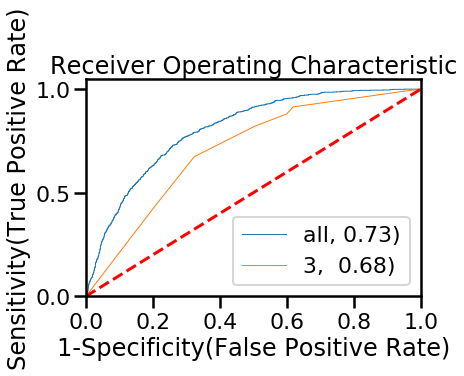

In [81]:
# Graph ROC Curve for all features and first 4 features 

from sklearn.metrics import roc_auc_score, roc_curve

plt.figure()

# Compute False postive rate, and True positive rate
#fpr4, tpr4, thresholds4 = metrics.roc_curve(y4_val, pipe_lr4.predict_proba(X4_val)[:,1])
fpr3, tpr3, thresholds3 = metrics.roc_curve(y3_val, pipe_lr3.predict_proba(X3_val)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_val, pipe_lr.predict_proba(X_val)[:,1])
#fprG, tprG, thresholdsG = metrics.roc_curve(y_val, pipe_lrGS.predict_proba(X_val)[:,1])
#fpr4G, tpr4G, thresholds4G = metrics.roc_curve(y4_val, pipe_lr4GS.predict_proba(X4_val)[:,1])

# Calculate Area under the curve to display on the plot
auc = metrics.roc_auc_score(y_val,pipe_lr.predict(X_val))
#auc4 = metrics.roc_auc_score(y4_val,pipe_lr4.predict(X4_val))
auc3 = metrics.roc_auc_score(y3_val,pipe_lr3.predict(X3_val))
#aucG = metrics.roc_auc_score(y_val,pipe_lrGS.predict(X_val))
#auc4G = metrics.roc_auc_score(y4_val,pipe_lr4GS.predict(X4_val))

# Now, plot the computed values
plt.plot(fpr, tpr, label='all, %0.2f)' % (auc),linewidth=1) 
#plt.plot(fprG, tprG, label='all_gs, %0.2f)' % (aucG),linewidth=1) 
#plt.plot(fpr4, tpr4, label='4,  %0.2f)' % (auc4),linewidth=1)
plt.plot(fpr3, tpr3, label='3,  %0.2f)' % (auc3),linewidth=1) 
#plt.plot(fpr4G, tpr4G, label='4_gs,  %0.2f)' % (auc4G),linewidth=1) 
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="best")
plt.show()

In [ ]:
bools = [True, False]

for prop1 in bools:
    for prop2 in bools:
        for prop3 in bools:
            for prop4 in bools:
                print(prop1, prop2, prop3, prop4)
                

In [ ]:
features = ['injury and poisoning', 'infectious', 'external injury', 'genitourinary']

total = df[df['injury and poisoning'] == True]['injury and poisoning'].count()
infected = df[(df['injury and poisoning'] == True) & (df['CLABSI'] == True)]['injury and poisoning'].count()
percent = round(infected/total*100)
print(percent)

In [ ]:
def find_percentages(injury,infectious,external,genitourinary):
    injury_count = df[(df['injury and poisoning'] == injury)]['injury and poisoning'].count()
    infectious_count = df[(df['infectious'] == infectious)]['infectious'].count()
    external_injury_count = df[(df['external injury'] == external)]['external injury'].count()
    genitourinary_count = df[(df['genitourinary'] == genitourinary)]['genitourinary'].count()                      
    total = injury_count + infectious_count + external_injury_count + genitourinary_count
                          
    #infected = df[(df['injury and poisoning'] == True) & (df['CLABSI'] == True)]['injury and poisoning'].count()
    #percent = round(infected/total*100)
    print(injury_count)
    print(infectious_count)
    return total

In [ ]:
find_percentages(True,False,False,False)

In [ ]:
pd.DataFrame()

# GridSearchCV for logistic regression

In [ ]:
# Create logistic regression
logistic = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [ ]:
best_model = clf.fit(X_train, y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

In [ ]:
# Predict target vector
best_model.predict(X_val)

In [ ]:
pipe_lrGS = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', C=3594, random_state=100))])

pipe_lrGS.fit(X_trainRes, y_trainRes)
predictions = pipe_lrGS.predict(X_valRes)
print(classification_report(y_valRes,predictions))
print(confusion_matrix(y_valRes,predictions))

In [ ]:
# Create logistic regression for 4 top features
logistic4 = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf4 = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [ ]:
best_model4 = clf4.fit(X4_train, y4_train)
print('Best Penalty:', best_model4.best_estimator_.get_params()['penalty'])
print('Best C:', best_model4.best_estimator_.get_params()['C'])

In [ ]:
pipe_lr4GS = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l1', C=1, random_state=100))])

pipe_lr4GS.fit(X4_trainRes, y4_trainRes)
predictions = pipe_lr4GS.predict(X4_valRes)
print(classification_report(y4_valRes,predictions))
print(confusion_matrix(y4_valRes,predictions))

In [ ]:
# Calculate percentages of manual approach on test set

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2,random_state=0)

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7643 entries, 34136 to 4308
Data columns (total 81 columns):
icustay_id                                      7637 non-null float64
starttime                                       7643 non-null datetime64[ns]
endtime                                         7643 non-null datetime64[ns]
duration_hours                                  7643 non-null float64
subject_id                                      7637 non-null float64
hadm_id                                         7637 non-null float64
dbsource                                        7637 non-null object
last_careunit                                   7637 non-null object
first_wardid                                    7637 non-null float64
last_wardid                                     7637 non-null float64
intime                                          7637 non-null datetime64[ns]
outtime                                         7637 non-null datetime64[ns]
los                    

In [10]:
# Patients with central lines and CLABSI: 
df_test[(df_test['duration_hours'] >0) & (df_test['CLABSI']==1)]['icustay_id'].count()

1279

In [11]:
# Patients with central lines and injury: 
df_test[(df_test['duration_hours'] >0) & (df_test['injury and poisoning']==1)]['icustay_id'].count()

4225

In [12]:
# Patients with central lines and injury and infections: 
(df_test[(df_test['duration_hours'] >0) &
         (df_test['injury and poisoning']==1) &
         (df_test['CLABSI']==1)
        ]['icustay_id'].count())

1058

In [14]:
recall = 1058/1279
recall 

0.8272087568412823

In [15]:
df_test['icustay_id'].count()

7637

In [16]:
# Patients to monitor: 
4225/7637

0.5532277072148749